# Porównanie rozkładów głosów z 4 losowo wybranych grup powiatów (bez głosów ze statków i zza granicy).

In [1]:
import random
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Ile powiatów brać pod uwagę w danej próbie
ILOSC_POWIATOW_PROBKA_1 = 100
ILOSC_POWIATOW_PROBKA_2 = 100
ILOSC_POWIATOW_PROBKA_3 = 10
ILOSC_POWIATOW_PROBKA_4 = 10
# Ile głosów losować z każdego powiatu
LICZBA_GLOSOW_Z_POWIATU = 500

In [3]:
# Wczytanie danych
df = pd.read_csv("wyniki_gl_na_kandydatow_po_powiatach_utf8.csv", sep=';')

In [4]:
# Określenie listy kandydatów do wyciągnięcia z pliku
kandydaci = [
    "TRZASKOWSKI Rafał Kazimierz",
    "NAWROCKI Karol Tadeusz",
    "MENTZEN Sławomir Jerzy",
    "BARTOSZEWICZ Artur",
    "BIEJAT Magdalena Agnieszka",
    "BRAUN Grzegorz Michał",
    "HOŁOWNIA Szymon Franciszek",
    "JAKUBIAK Marek",
    "MACIAK Maciej",
    "SENYSZYN Joanna",
    "STANOWSKI Krzysztof Jakub",
    "WOCH Marek Marian",
    "ZANDBERG Adrian Tadeusz"
]

# Usunięcie wierszy z brakującym kodem TERYT powiatu
df = df.dropna(subset=["TERYT Powiatu"])

do_wyciagniecia = ["TERYT Powiatu"] + kandydaci

# Stworzenie słownika dla późniejszego identyfikowania powiatów po kodach TERYT
teryt_powiat = dict(zip(df["TERYT Powiatu"], df["Powiat"]))

# Uzyskanie listy kodów powiatów
wszystkie_powiaty = df["TERYT Powiatu"].unique()
print(f"Liczba unikalnych powiatów: {len(wszystkie_powiaty)}")

suma_glosow_plik = df[kandydaci].sum().sum()
print(f"Liczba wszystkich głosów w pliku (bez głosów zza granicy): {suma_glosow_plik:,}")

Liczba unikalnych powiatów: 380
Liczba wszystkich głosów w pliku (bez głosów zza granicy): 19,137,917


In [5]:
# Losowanie określonej liczby gmin do każdej próbki
probki = [random.sample(list(wszystkie_powiaty), ilosc_powiatow) 
          for ilosc_powiatow in 
          [ILOSC_POWIATOW_PROBKA_1, ILOSC_POWIATOW_PROBKA_2, ILOSC_POWIATOW_PROBKA_3, ILOSC_POWIATOW_PROBKA_4]
]

In [6]:
# Słownik na wyniki dla poszczególnych próbek
wyniki_probek = {}

for i, lista_powiatow in enumerate(probki, start=1):
    # Inicjalizacja listy głosów dla danej próbki
    lista_glosow_probka = []

    # Zamiana kodów TERYT na nazwy powiatów
    nazwy_powiatow = [teryt_powiat.get(teryt) for teryt in lista_powiatow]

    for teryt in lista_powiatow:
        # Filtrowanie danych dla pojedyńczego powiatu
        df_powiat = df[df['TERYT Powiatu'] == teryt][do_wyciagniecia]

        # Zliczenie głosów na wybranych kandydatów w powiecie
        glosy_z_powiatu = {
            "Trz": int(df_powiat["TRZASKOWSKI Rafał Kazimierz"].sum()),
            "Naw": int(df_powiat["NAWROCKI Karol Tadeusz"].sum()),
            "Men": int(df_powiat["MENTZEN Sławomir Jerzy"].sum()),
            "Bra": int(df_powiat["BRAUN Grzegorz Michał"].sum()),
            "Hol": int(df_powiat["HOŁOWNIA Szymon Franciszek"].sum()),
            "Zan": int(df_powiat["ZANDBERG Adrian Tadeusz"].sum()),
            "Bie": int(df_powiat["BIEJAT Magdalena Agnieszka"].sum()),
            "Sta": int(df_powiat["STANOWSKI Krzysztof Jakub"].sum()),
            "Sen": int(df_powiat["SENYSZYN Joanna"].sum()),
            "Jak": int(df_powiat["JAKUBIAK Marek"].sum()),
            "Bar": int(df_powiat["BARTOSZEWICZ Artur"].sum()),
            "Mac": int(df_powiat["MACIAK Maciej"].sum()),
            "Woc": int(df_powiat["WOCH Marek Marian"].sum())
        }
    
        # Rozbicie głosów na listę
        lista_glosow_powiat = []
        for kandydat, liczba_glosow in glosy_z_powiatu.items():
            lista_glosow_powiat.extend([kandydat] * liczba_glosow)

        # Ograniczenie liczby głosów z powiatu
        if len(lista_glosow_powiat) > LICZBA_GLOSOW_Z_POWIATU:
            lista_glosow_probka.extend(random.sample(lista_glosow_powiat, LICZBA_GLOSOW_Z_POWIATU))
        else:
            lista_glosow_probka.extend(lista_glosow_powiat)

    # Sumowanie głosów z całej próbki
    sumowane_glosy = dict(Counter(lista_glosow_probka))

    # Zapisanie wyników próbki
    wyniki_probek[f"probka_{i}"] = {
        "powiaty": lista_powiatow,
        "nazwy_powiatow": nazwy_powiatow,
        "glosy": lista_glosow_probka,
        "sumowane_glosy": sumowane_glosy
    }

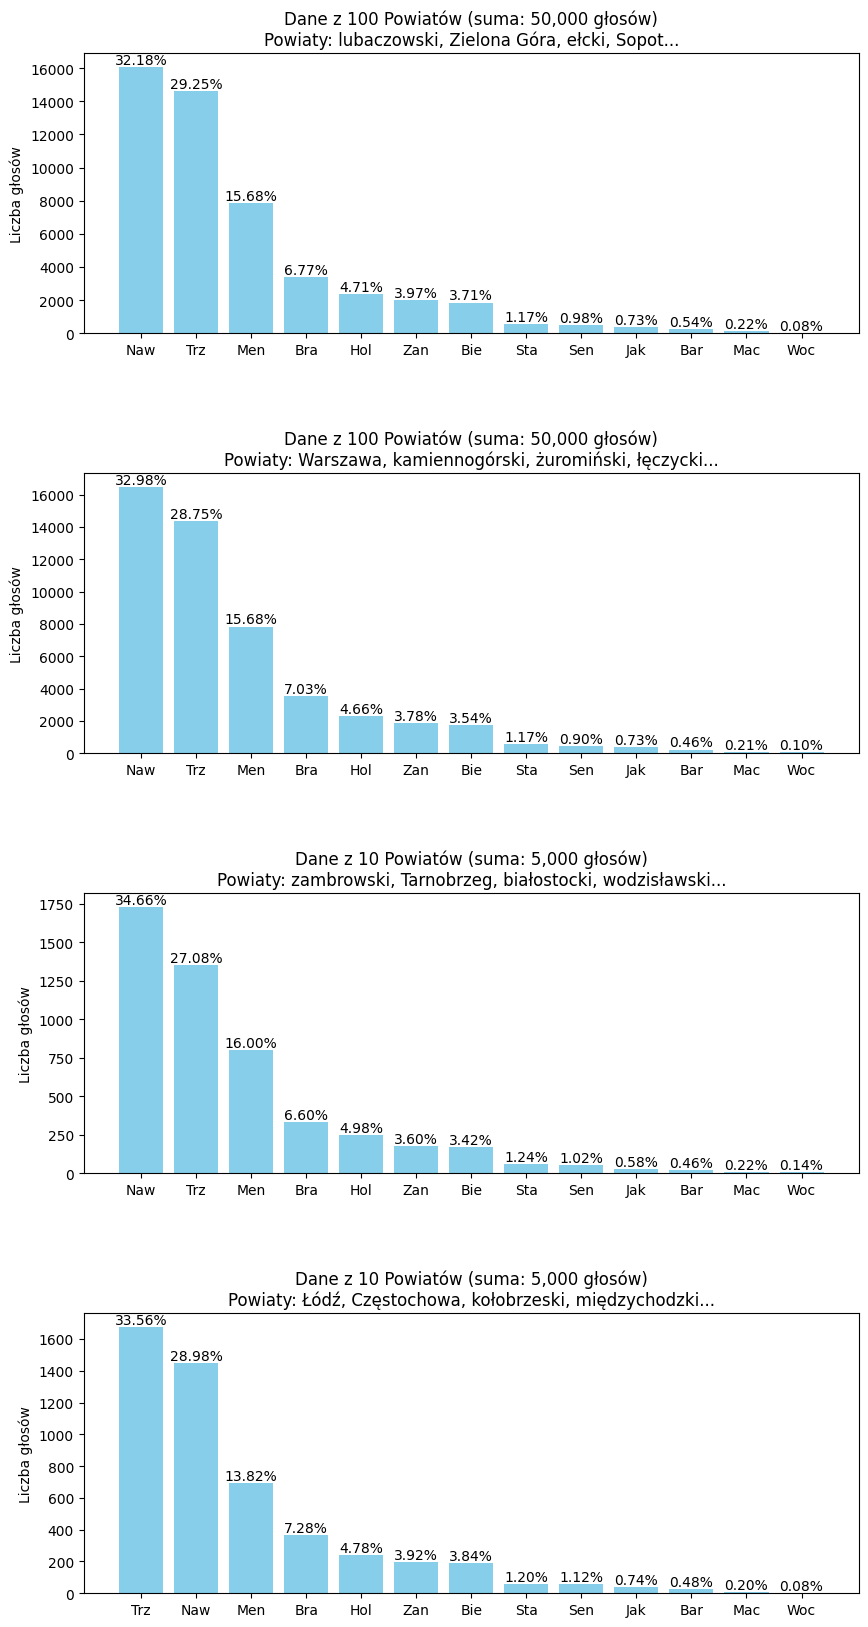

In [8]:
# Przygotowanie czterech wykresów, ułożonych pionowo jeden pod drugim
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10,20))
fig.subplots_adjust(hspace=0.5)

# Iteracja jednocześnie po każdym wykresie oraz odpowiadającej mu próbce danych
# axs to lista osi, a probki to lista krotek (nazwa, probka)
for ax, (nazwa, dane) in zip(axs, wyniki_probek.items()):
    lista_powiatow = dane["nazwy_powiatow"]
    # Liczenie głosów w danej próbce za pomocą Counter
    licznik_probki = dane["sumowane_glosy"]
    # Sortowanie wyników malejąco według liczby głosów
    posortowana_probka = sorted(licznik_probki.items(), key=lambda x: x[1], reverse=True)
    # Rozpakowanie posortowanych danych na osobne listy
    posortowani_kandydaci, posortowane_glosy = zip(*posortowana_probka)
    # Obliczenie sumy dla późniejszego liczenia procentów
    suma_glosow = sum(posortowane_glosy)

    # Rysowanie wykresu słupkowego i zapisanie obiektów słupków do zmiennej bars
    bars = ax.bar(posortowani_kandydaci, posortowane_glosy, color='skyblue')

    skrocone_powiaty = ', '.join(lista_powiatow[:4]) + ('...' if len(lista_powiatow) > 4 else '')
    
    # Dodanie tytułu wykresu oraz pospisu osi y
    ax.set_title(f"Dane z {len(dane['powiaty'])} {'Powiatów' if len(dane['powiaty']) > 1 else 'Powiatu'} (suma: {suma_glosow:,} głosów)\nPowiaty: {skrocone_powiaty}")
    ax.set_ylabel(f"Liczba głosów")

    # Iteracja jednocześnie po słupkach w zmiennej bars oraz po liczbach głosów w krotce posortowane_glosy
    for bar, glosy_kandydata in zip(bars, posortowane_glosy):
        wysokosc = bar.get_height()
        # Obliczenie procentów
        procent = glosy_kandydata / suma_glosow * 100
        # plt.text(x, y, tekst) dodaje tekst do wykresu w punkcie o współrzędnych (x, y)
        # w tym przypadku ax.text umiescza wartości procentowe nad każdym słupkiem
        ax.text(bar.get_x() + bar.get_width()/2, wysokosc, f"{procent:.2f}%", ha='center', va='bottom')

plt.show()